In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

# I- Data preparation

We'll use a dataset of historical returns and realized covariance of the main stock market indexes (Eurostoxx 500, S&P 500,...). Realized covariance on day $t$ between index $i$ and $j$ is estimated by: 
$$Cov_{t,i,j} = \rho_{t,i,j} \sigma_{t,i} \sigma_{t,j}$$
Where $\rho_{t,i,j}$ is the historical correlation up to time $t$ between returns of index $i$ (60 days of returns) and $j$ and $\sigma_{t,i}$ is the realized volatility of index $i$ during day $t$ (computed with datapoints with a 5 minutes frequency during day $t$.)

In [3]:
df = pd.read_csv("oxfordmanrealizedvolatilityindices.csv")
df = df.rename(columns={'Unnamed: 0': 'date'})
# df =df[~df['Symbol'].isin(['.MXX'])]
df['date'] = pd.to_datetime(df['date'])

#pivot pour passer de format long à wide 
pivot_prices = df.pivot(index='date', columns='Symbol', values='close_price')
pivot_rv5 = df.pivot(index='date', columns='Symbol', values='rv5')

#on combine les 2 pivot tables
combined = pivot_prices.join(pivot_rv5, lsuffix='_price', rsuffix='_rv')


#we toss the assets for wich there are more than 5% of missing values (and we will do forward fill on others)
threshold = len(combined) * 0.1
missing_counts = combined.isna().sum()
cols_to_drop = missing_counts[missing_counts > threshold].index
print(f"removed assets : {cols_to_drop.tolist()}")

combined = combined.drop(columns=cols_to_drop)
combined = combined.ffill()
combined = combined.dropna()



# Séparation après nettoyage
prices = combined.filter(like='_price')
variances = combined.filter(like='_rv')

# Renommage des colonnes pour avoir juste les symboles
prices.columns = [c.replace('_price', '') for c in prices.columns]
variances.columns = [c.replace('_rv', '') for c in variances.columns]

#Compute returns and realized covariances 
returns_df = prices.pct_change()
realized_vol_df = np.sqrt(variances)

# realign datasets 
valid_idx = returns_df.index.intersection(realized_vol_df.index)
returns_df = returns_df.loc[valid_idx].dropna()
realized_vol_df = realized_vol_df.loc[returns_df.index]

#Compute realized correlations (rollign window of 60 days)
# crée un objet MultiIndex (Date x Symbol) pour les corrélations
rolling_corr = returns_df.rolling(window=60).corr() 

# On doit supprimer les premiers jours (car on n'a pas les 60 premieres valeurs de correlation)
returns_df = returns_df.iloc[60:]
realized_vol_df = realized_vol_df.iloc[60:]
valid_dates = returns_df.index

#construction of the tensor containing realized covariances
T = len(valid_dates)
N = len(returns_df.columns)

# Structures finales
cov_tensor = np.zeros((T, N, N))
returns_matrix = returns_df.values

assets = returns_df.columns.tolist()
dates = valid_dates.values

for t, date in enumerate(valid_dates):
    # vector containing daily realized volatilities (oxford data)
    sigma_vec = realized_vol_df.loc[date].values
    
    # matrix of estimated realized covariance matrix, built from daily realized volatility and historical correlations (computed over 60 days)
    R = rolling_corr.loc[date].values
        
    # Cov = Sigma_outer * R
    # avec Sigma_outer = matrice des produits sigma_i * sigma_j pour la date t 
    Sigma_outer = np.outer(sigma_vec, sigma_vec)
    V_real = Sigma_outer * R
    
    cov_tensor[t, :, :] = V_real



data = {
    'dates': dates,
    'assets': assets,
    'returns': returns_matrix,      
    'realized_covs': cov_tensor     
}

C:\Users\jean-\AppData\Local\Temp\ipykernel_19580\2323202665.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])


removed assets : ['.BVLG_price', '.FTMIB_price', '.GSPTSE_price', '.OMXC20_price', '.OMXHPI_price', '.OMXSPI_price', '.OSEAX_price', '.SMSI_price', '.STI_price', '.BVLG_rv', '.FTMIB_rv', '.GSPTSE_rv', '.OMXC20_rv', '.OMXHPI_rv', '.OMXSPI_rv', '.OSEAX_rv', '.SMSI_rv', '.STI_rv']


Because of missing data in the dataset, we've kept only 14 indexes. These are the index for which there is no (or very little) missing data, with less than 5% of data missing. 

In [4]:
print("dates:",data['dates'][:5])
print("assets:",data['assets'])
print("first day return",data['returns'][0])
print("first day realized covariance",data['realized_covs'][0])

dates: [Timestamp('2000-04-27 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-04-28 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-05-01 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-05-02 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-05-03 00:00:00+0100', tz='UTC+01:00')]
assets: ['.AEX', '.AORD', '.BFX', '.BSESN', '.BVSP', '.DJI', '.FCHI', '.FTSE', '.GDAXI', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.RUT', '.SPX', '.SSEC', '.SSMI', '.STOXX50E']
first day return [-0.02467135 -0.00285798 -0.01608623 -0.02422328 -0.00040463 -0.00575347
 -0.02405161 -0.01168561 -0.02350857 -0.00226697 -0.01815965  0.03957998
 -0.02767962  0.00369437  0.0139123  -0.00805182 -0.01336954  0.02135305
  0.00198482 -0.01415828 -0.00497459 -0.01490569]
first day realized covariance [[ 2.00287197e-04  3.59998425e-05  7.75084649e-05  3.02789962e-05
   7.62080367e-05  2.52341329e-05  2.16483810e-04  1.45995491e-04
   2.16486098e-04  1.26180759e-04  1.29895554e-04  1.40314153e-0

# II- Online portfolio construction

For now, we don't add any forecasts of covariance and returns to the experiments but we will motivate the interest of online learning and its robustness to adversarial environments by comparing the following portfolios.
- equal weights portfolio 
- Markowitz portfolio (without short-selling and leverage) on the average of returns and realized covariance on the last 60 days. 
- Markowitz portfolio (without short-selling and leverage) on the average of returns and realized covariance on the full history. This portfolio is equivalent to a Follow-The-Leader algorithm 
- Online gradient descent/FTRL portfolio with regularizer $R(w) = \frac{1}{2}\|w\|_2^2$:
$$w_{t+1} =  \arg\max_{w \in \Delta_N} \langle \nabla f_t(w_t),w \rangle - \frac{1}{2\eta}\|w-w_t\|_2^2 =  \arg\max_{w \in \Delta_N} \eta \sum_{s=0}^t f_s(w) - \frac{1}{2}\|w\|_2^2$$
$$ \Leftrightarrow w_{t+1} = \text{Proj}_{\Delta_N}(w_t + \eta \nabla f_t(w_t))$$
- Exponentiated gradient/FTRL with negative entropy regularizer:
$$ w_{t+1} =\arg\max_{w \in \Delta_N} \eta \sum_{s=0}^t f_s(w) + \sum_{i=1}^Nw_i log (w_i) $$
$$ \Leftrightarrow w_{t+1} = \left( \frac{e^{\eta \sum_{i=1}^{t}\nabla f_s(w_s)_k}}{\sum_{j=1}^Ne^{\eta \sum_{i=1}^{t}\nabla f_s(w_s)_j}}\right)_{ 1 \leq k \leq N} $$

The Exponentiated gradient algorithm is expected to work better than the OGD algorithm as the negative entropy regularizer is better suited to the geometry of the simplex and yields tighter regret bounds from a mathematical perspective (allows to remove some dependence in the dimension/number of assets in the regret bound).


Regarding the learning rate used by the online learning algorithms: we'll use the RMSProp approach to tune the learning rate, ie set: 
$$ \eta_t = \frac{\eta_{base}}{\sqrt{A_t} + \epsilon}$$
where $A_t =  \gamma A_{t-1} + (1- \gamma) \|\nabla f_t(w_t)\|^2$ is the quadratic moving average of the gradient.


In [5]:
#  projection on simplex of a vector v
def project_to_simplex(v):
    
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

# quadratic program solver for markowitz portfolio
def solve_qp(mu_est, Sigma_est, risk_aversion):
    """
    Résout: Max w^T*mu - (lambda/2) * w^T*Sigma*w
    Sujet à: sum(w)=1, w>=0
    """
    N = len(mu_est)
    w = cp.Variable(N)
    gamma = cp.Parameter(nonneg=True, value=risk_aversion)
    # we add a small regularization to Sigma to ensure it's positive definite
    Sigma_est = Sigma_est + np.eye(N) * 1e-6

    # Objectif : Maximiser le rendement ajusté du risque
    # Note: cvxpy minimise, donc on minimise -(Rendement - Penalité)
    ret = mu_est @ w
    risk = cp.quad_form(w, cp.psd_wrap(Sigma_est))
    prob = cp.Problem(cp.Maximize(ret - (gamma / 2) * risk), 
                      [cp.sum(w) == 1, w >= 0])
    
    try:
        prob.solve(solver=cp.OSQP, warm_start=True) 
        return w.value
    except Exception as e:
        print("failed to compute markowitz solution",e)



def calculate_annualized_sharpe_ratio(wealth_series, risk_free_rate=0.0, periods_per_year=252):

    returns = pd.Series(wealth_series).pct_change().dropna()
    mean_return = returns.mean()
    std_return = returns.std()
    # Formule : (Moyenne - Rf) / Volatilité * Racine(Périodes)
    # Note: On suppose Rf journalier ~ 0 pour simplifier
    sharpe = (mean_return - risk_free_rate) / std_return
    annualized_sharpe = sharpe * np.sqrt(periods_per_year)
    
    return annualized_sharpe


def get_rolling_sharpe(wealth_array, window, rf=0.0):

    s = pd.Series(wealth_array)

    returns = s.pct_change()

    roll_mean = returns.rolling(window).mean()
    roll_std = returns.rolling(window).std()
    
    rolling_sharpe = (roll_mean - rf) / roll_std * np.sqrt(252)
    
    return rolling_sharpe

In [116]:
dates = data['dates']
returns = data['returns']        
covs = data['realized_covs']     
assets = data['assets']

T, N = returns.shape

# Parameters of the model
lambda_reg = 25   # risk aversion parameter of utility functions: allows to play on the level of diversification of the portfolio and on the risk/return tradeoff
lr_ogd = 0.1 
lr_eg = 1         # Learning Rate for FTRL / OMD 
window = 120       # rolling window for Markowitz rolling mean 

ma_eg = 0.0  # Moving average of the gradient 
ma_ogd = 0.0
decay = 0.9        # decay factor 
lr_base_eg = 0.1      # Learning rate 
lr_base_ogd = 0.01      # Learning rate
epsilon = 1e-6     # to avoid dividing by zero

#initialization of variables 
#OGD
w_ogd = np.ones(N) / N
wealth_ogd = [1.0]

#OGD with adaptive learning date
w_ogd_ada = np.ones(N) / N
wealth_ogd_ada = [1.0]

#EG
w_eg = np.ones(N) / N
wealth_eg = [1.0]

#EG with adaptive learning date
w_eg_ada = np.ones(N) / N
wealth_eg_ada = [1.0]

#Markowitz Rolling 
w_marko_roll = np.ones(N) / N
wealth_marko_roll = [1.0]

#Markowitz Full History 
w_marko_full = np.ones(N) / N
wealth_marko_full = [1.0]

#Benchmark
wealth_eq = [1.0]

#history of weights 
hist_w_ogd = []
hist_w_ogd_ada = []
hist_w_eg = []
hist_w_eg_ada = []
hist_w_marko_roll = []
hist_w_marko_full = []


#we start the experiment at day 60 to have enough data to feed the markowitz portfolio
#but we need to warm up OMD before that even if we don't invest in it
for t in range(0, window):

    r_t = returns[t]
    V_t_real = covs[t]

    #gradient for OGD
    grad = r_t - lambda_reg * (V_t_real @ w_ogd)
    w_ogd = project_to_simplex(w_ogd + lr_ogd * grad)

    #gradient for OGD with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_ogd_ada)
    #update learning rate
    ma_ogd = decay*ma_ogd + (1-decay)*np.sum(grad**2)
    lr_ogd_ada = lr_base_ogd / (np.sqrt(ma_ogd) + epsilon)
    #compute portfolio
    w_ogd_ada = project_to_simplex(w_ogd_ada + lr_ogd_ada * grad)

    #gradient for exponentiated gradient algorithm
    grad = r_t - lambda_reg * (V_t_real @ w_eg)
    w_eg = w_eg*np.exp(lr_eg * grad)/np.sum(w_eg*np.exp(lr_eg * grad))

    #gradient for EG with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_eg_ada)
    #update learning rate
    ma_eg = decay*ma_eg + (1-decay)*np.sum(grad**2)
    lr_eg_ada = lr_base_eg / (np.sqrt(ma_eg) + epsilon)
    #compute portfolio
    w_eg_ada = w_eg_ada*np.exp(lr_eg_ada * grad)/np.sum(w_eg_ada*np.exp(lr_eg_ada * grad))

for t in tqdm(range(window, T)):
    
    # we compute performance of portfolios on day t (from weights that were computed at t-1)
    r_t = returns[t]          
    V_t_real = covs[t]        
    
    ret_ogd = np.dot(w_ogd, r_t)
    ret_ogd_ada = np.dot(w_ogd_ada, r_t)
    ret_eg = np.dot(w_eg, r_t)
    ret_eg_ada = np.dot(w_eg_ada, r_t)
    ret_marko_roll = np.dot(w_marko_roll, r_t)
    ret_marko_full = np.dot(w_marko_full, r_t)
    ret_eq = np.mean(r_t)
    
    # update wealth of each portfolio
    wealth_ogd.append(wealth_ogd[-1] * (1 + ret_ogd))
    wealth_ogd_ada.append(wealth_ogd_ada[-1] * (1 + ret_ogd_ada))
    wealth_eg.append(wealth_eg[-1] * (1 + ret_eg))
    wealth_eg_ada.append(wealth_eg_ada[-1] * (1 + ret_eg_ada))
    wealth_marko_roll.append(wealth_marko_roll[-1] * (1 + ret_marko_roll))
    wealth_marko_full.append(wealth_marko_full[-1] * (1 + ret_marko_full))
    wealth_eq.append(wealth_eq[-1] * (1 + ret_eq))
    
    # update history of weights 
    hist_w_ogd.append(w_ogd)
    hist_w_ogd_ada.append(w_ogd_ada)
    hist_w_eg.append(w_eg)
    hist_w_eg_ada.append(w_eg_ada)
    hist_w_marko_roll.append(w_marko_roll)
    hist_w_marko_full.append(w_marko_full)
    

    # update portfolios for day t+1
    # 1. UPDATE OMD 
    # Gradient of f_t(w) = <r_t, w> - lambda/2 * w.T * V_t * w is:
    # Grad = r_t - lambda * V_t * w
    grad = r_t - lambda_reg * (V_t_real @ w_ogd)
    # gradient update and projection on simplex 
    w_temp = w_ogd + lr_ogd * grad
    w_ogd = project_to_simplex(w_temp)


    #1' UPDATE OMD WITH ADAPTIVE GRADIENT 
    #gradient for OGD with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_ogd_ada)
    #update learning rate
    ma_ogd = decay*ma_ogd + (1-decay)*np.sum(grad**2)
    lr_ogd_ada = lr_base_ogd / (np.sqrt(ma_ogd) + epsilon)
    #compute portfolio
    w_ogd_ada = project_to_simplex(w_ogd_ada + lr_ogd_ada * grad)


    # 1''. UPDATE EG
    grad = r_t - lambda_reg * (V_t_real @ w_eg)
    w_eg = w_eg*np.exp(lr_eg * grad)/np.sum(w_eg*np.exp(lr_eg * grad))

    # 1''' UPDATE EG WITH ADAPTIVE GRADIENT
    #gradient for EG with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_eg_ada)
    #update learning rate
    ma_eg = decay*ma_eg + (1-decay)*np.sum(grad**2)
    lr_eg_ada = lr_base_eg / (np.sqrt(ma_eg) + epsilon)
    #compute portfolio
    w_eg_ada = w_eg_ada*np.exp(lr_eg_ada * grad)/np.sum(w_eg_ada*np.exp(lr_eg_ada * grad))

    
    # 2. UPDATE MARKOWITZ ROLLING
    idx_start = t - window + 1
    idx_end = t + 1
    mu_roll = np.mean(returns[idx_start:idx_end], axis=0)
    sigma_roll = np.mean(covs[idx_start:idx_end], axis=0)
    w_marko_roll = solve_qp(mu_roll, sigma_roll, lambda_reg)
    
    # 3. UPDATE MARKOWITZ FULL HISTORY (Depuis le début)
    mu_full = np.mean(returns[:idx_end], axis=0)
    sigma_full = np.mean(covs[:idx_end], axis=0)
    w_marko_full = solve_qp(mu_full, sigma_full, lambda_reg)
    


  0%|          | 0/4644 [00:00<?, ?it/s]

100%|██████████| 4644/4644 [02:04<00:00, 37.17it/s]


In [10]:
def plot_strategy_performance(strategies, dates, window, weight_histories=None, assets=None):
    
    # Alignement des dates pour l'affichage (on suppose que wealth commence après 'window')
    plot_dates = dates[window:]
    
    # ==========================================
    # 1. CUMULATIVE WEALTH PLOT
    # ==========================================
    plt.figure(figsize=(12, 6))
    
    for name, wealth in strategies.items():
        # Sécurité : alignement des dimensions
        # Le wealth array a souvent 1 élément de plus (le 1.0 initial) ou correspond exactement
        if len(wealth) > len(plot_dates):
            # On suppose wealth = [1.0, w1, w2...] et plot_dates correspond à t=1..T
            y_values = wealth[1:] 
        else:
            y_values = wealth
            
        # Truncate to match shortest length just in case
        limit = min(len(plot_dates), len(y_values))
        plt.plot(plot_dates[:limit], y_values[:limit], label=name, linewidth=1.5)

    plt.title("Wealth Evolution Comparison")
    plt.ylabel("Cumulative Wealth")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================
    # 2. SHARPE RATIO BAR CHART
    # ==========================================
    sharpe_results = {}
    for name, wealth in strategies.items():
        sharpe_results[name] = calculate_annualized_sharpe_ratio(wealth)
        
    plt.figure(figsize=(12, 6))
    names = list(sharpe_results.keys())
    values = list(sharpe_results.values())
    
    bars = plt.bar(names, values, alpha=0.7, edgecolor='black', color=plt.cm.tab10(np.arange(len(names))))

    plt.title("Annualized Sharpe Ratio by Strategy")
    plt.ylabel("Sharpe Ratio")
    plt.axhline(0, color='black', linewidth=0.8) 
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')

    # Valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        offset = 0.05 if height >= 0 else -0.15
        plt.text(bar.get_x() + bar.get_width()/2., height + offset,
                 f'{height:.2f}',
                 ha='center', va='bottom' if height >=0 else 'top', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ==========================================
    # 3. ROLLING SHARPE RATIO
    # ==========================================
    plt.figure(figsize=(12, 6))
    rolling_window_sharpe = 252 # 1 an de trading
    
    for name, wealth in strategies.items():
        sharpe_series = get_rolling_sharpe(wealth, rolling_window_sharpe)
        
        # Alignement dates / séries
        # La série rolling aura des NaN au début
        if len(plot_dates) == len(sharpe_series):
            plt.plot(plot_dates, sharpe_series, label=name, linewidth=1.5)
        else:
            # Gestion basique des décalages de taille
            limit = min(len(plot_dates), len(sharpe_series))
            plt.plot(plot_dates[-limit:], sharpe_series.iloc[-limit:], label=name, linewidth=1.5)

    plt.title(f"Rolling Annualized Sharpe Ratio ({rolling_window_sharpe}-day window)")
    plt.ylabel("Sharpe Ratio")
    plt.xlabel("Date")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 4. WEIGHTS STACKPLOTS (Optionnel)
    # ==========================================
    if weight_histories is not None and assets is not None:
        for name, history in weight_histories.items():
            plt.figure(figsize=(10, 5))
            
            # Conversion en array numpy si liste
            hist_arr = np.array(history)
            
            # Vérification dimensions pour le plot
            # stackplot demande (x, y1, y2...) où y sont de dimension (N, T)
            # hist_arr est souvent (T, N), donc on transpose -> .T
            
            # Alignement temporel : history a souvent été rempli pendant la boucle
            # Il faut s'assurer que sa longueur matche plot_dates
            limit = min(len(plot_dates), hist_arr.shape[0])
            
            plt.stackplot(plot_dates[:limit], hist_arr[:limit].T, labels=assets)
            
            plt.title(f"Evolution of weights: {name}")
            plt.ylabel("Allocation")
            plt.xlabel("Date")
            
            # Légende à l'extérieur pour ne pas cacher le graph
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)
            plt.tight_layout()
            plt.show()

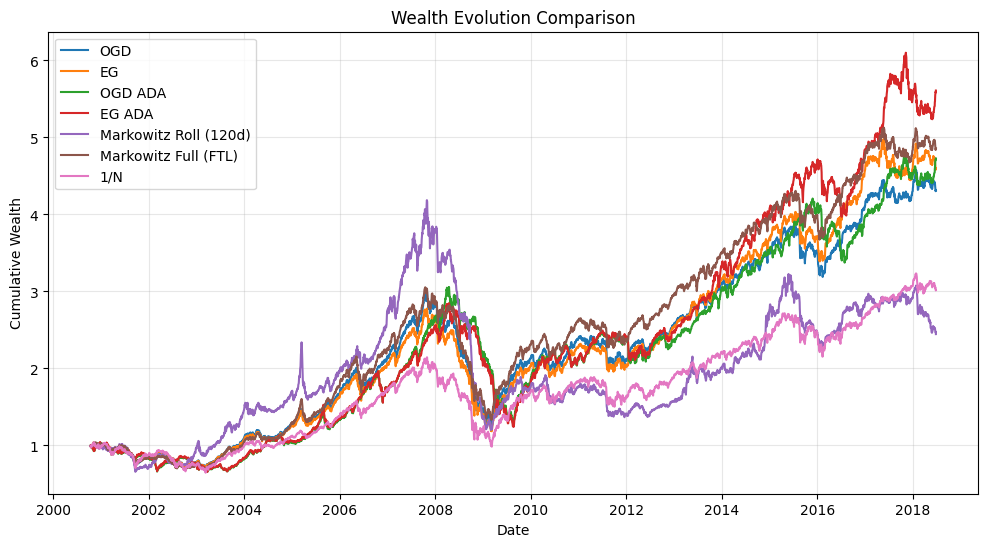

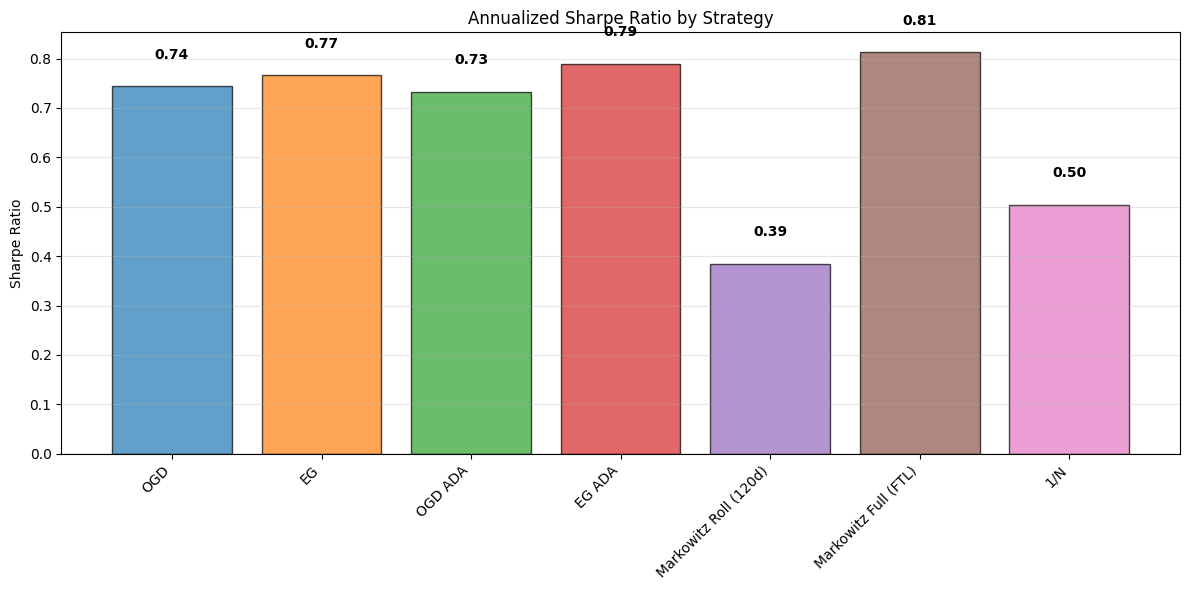

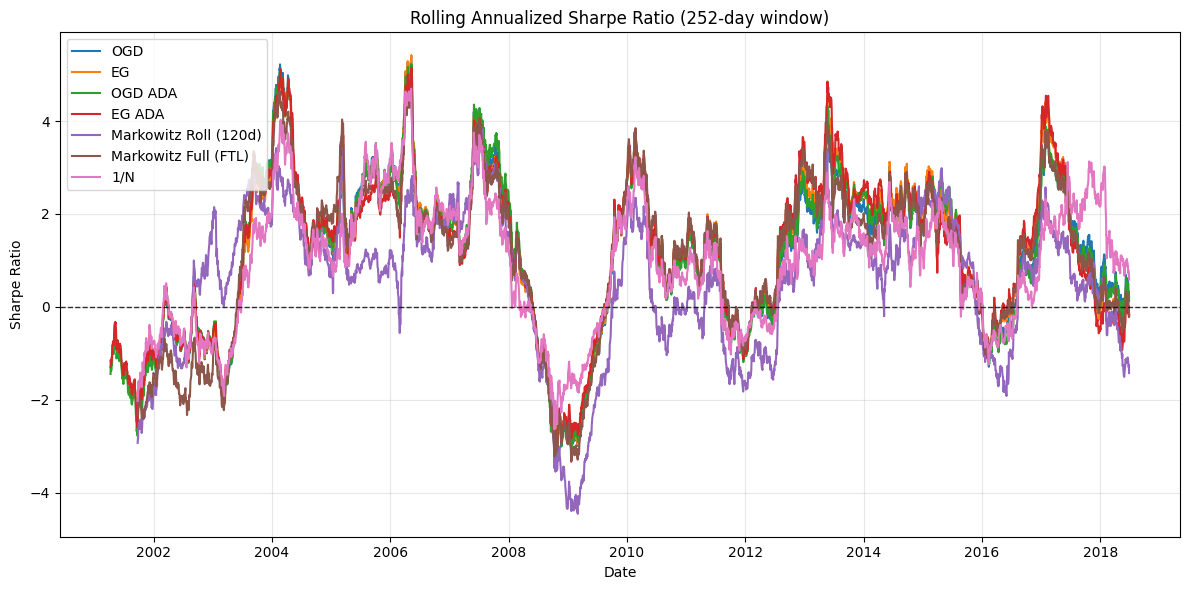

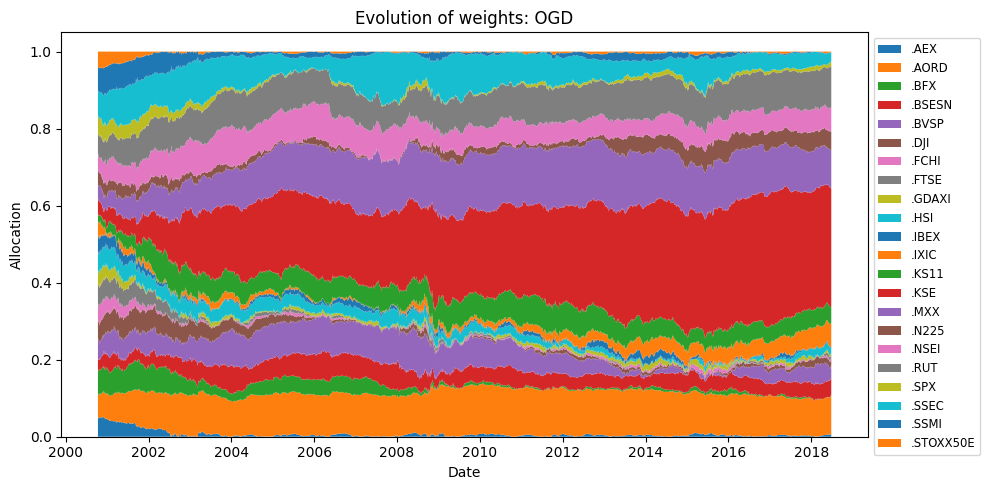

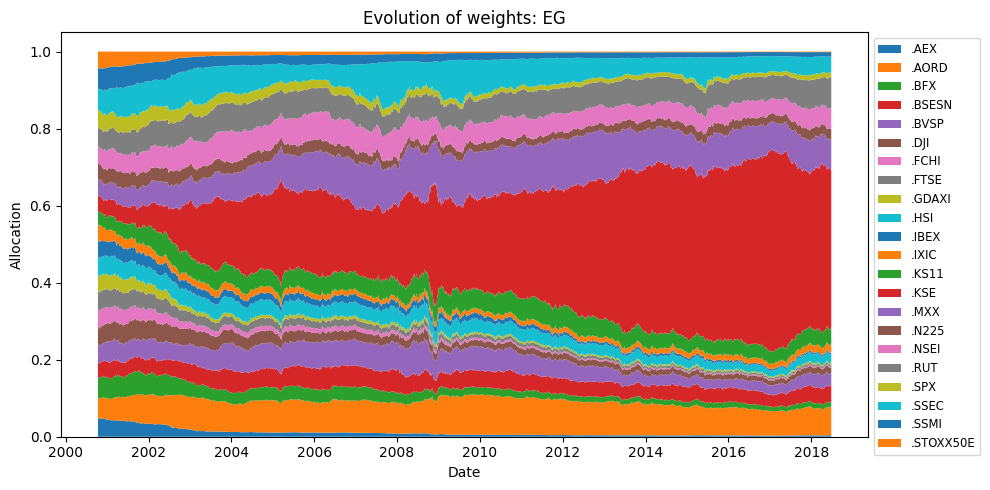

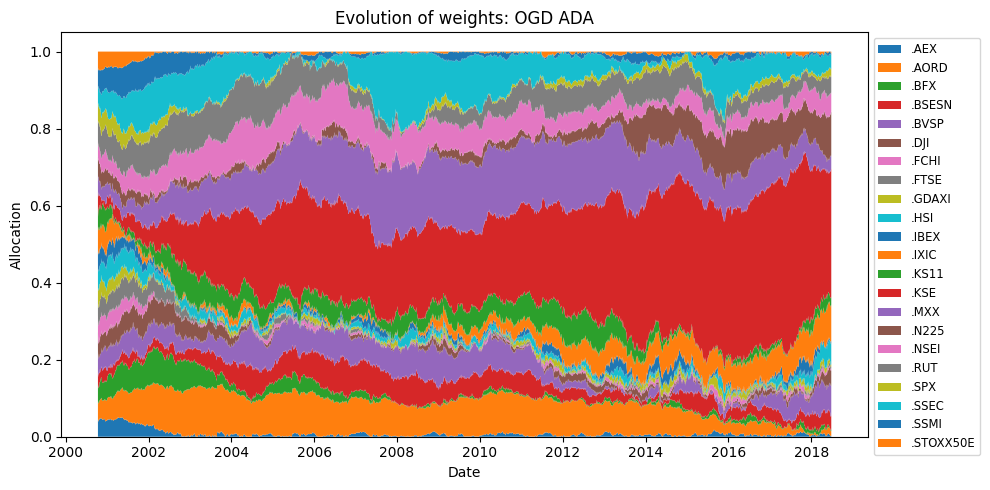

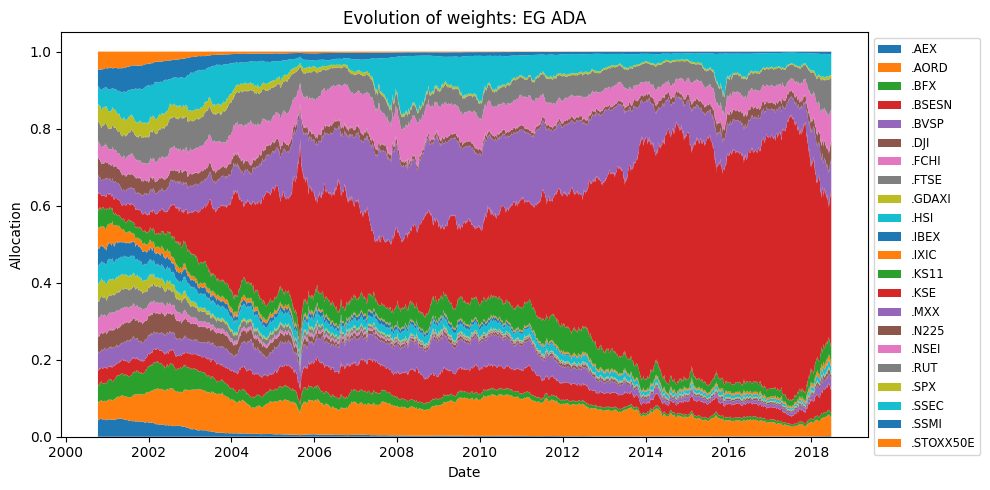

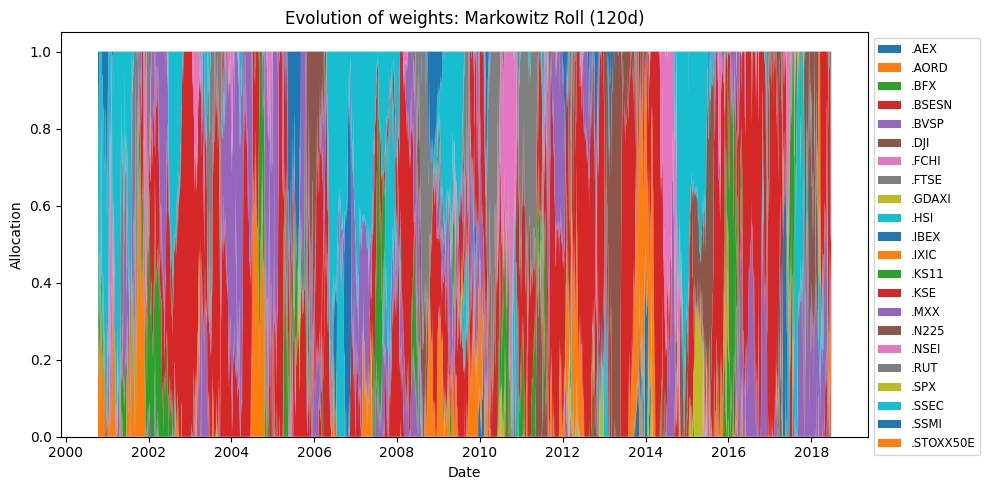

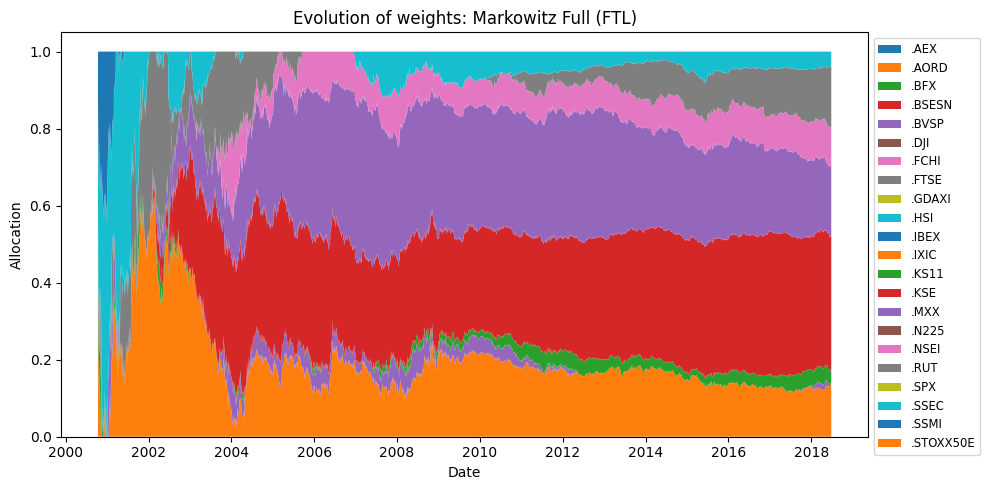

In [122]:
# 1. Dictionnaire des richesses (Wealth)
strategies = {
    'OGD': wealth_ogd,
    'EG': wealth_eg,
    'OGD ADA': wealth_ogd_ada,
    'EG ADA': wealth_eg_ada,
    f'Markowitz Roll ({window}d)': wealth_marko_roll,
    'Markowitz Full (FTL)': wealth_marko_full,
    '1/N': wealth_eq
}

# 2. Dictionnaire des historiques de poids (Optionnel)
# Note : Assurez-vous d'avoir sauvegardé hist_w_marko_pred dans la boucle précédente
weights_dict = {
    'OGD': hist_w_ogd,
    'EG':  hist_w_eg,
    'OGD ADA': hist_w_ogd_ada,
    'EG ADA': hist_w_eg_ada,
    f'Markowitz Roll ({window}d)': hist_w_marko_roll,
    'Markowitz Full (FTL)': hist_w_marko_full,
}


# 3. Appel de la fonction
plot_strategy_performance(
    strategies=strategies,
    dates=dates,
    window=window,
    weight_histories=weights_dict, # Mettre None si vous ne voulez pas les stackplots
    assets=assets
)

# Motivation for using online learning in portfolio selection: 
- Before the 2008 crisis, the Markowitz portfolio performs better than all online learning portfolios. We're indeed in a trend-following period, past returns are predictive of future returns, meaning that the Markowitz portfolio manages to capture which assets will perform well. 
- However, in 2008, the market crashes and the performance of Markowitz portfolio declines very severely. The online learning portfolios performance declines much less severely and in the middle of the crisis, the online learning portfolios all start overperforming the Markowitz portfolio. **This robust behavior of online learning portfolios during the crisis is explained by the robustness of online learning algorithms to adversarial environments. This motivates the use of online learning to develop portfolios that are robust to financial crisis and more generally to adversarial periods.**

## IV- Incorporating predictions

In [14]:

dates = data['dates']
returns = data['returns']        
covs = data['realized_covs']     
assets = data['assets']

T, N = returns.shape

# --- Paramètres du modèle ---
lambda_reg = 25   
window = 120      

# Paramètres Learning Rates Adaptatifs (OGD/EG)
decay = 0.9        
lr_base_eg = 0.1      
lr_base_ogd = 0.01      
epsilon = 1e-6     

# Paramètres de la Perturbation (Le "Bruit")
# noise_level : Ecart-type du bruit ajouté (ex: 0.001 = 0.1% de bruit quotidien)
noise_level_mu = 0.5  
noise_level_sigma = 0.1 

# --- Initialisation des variables ---

# 1. OGD Adaptatif
w_ogd_ada = np.ones(N) / N
wealth_ogd_ada = [1.0]
ma_ogd = 0.0 # Moving average of gradient squared

# 2. EG Adaptatif
w_eg_ada = np.ones(N) / N
wealth_eg_ada = [1.0]
ma_eg = 0.0 

# 3. Markowitz "Oracle" (Rolling avec prédiction bruitée)
w_marko_pred = np.ones(N) / N
wealth_marko_pred = [1.0]

# Historique des poids
hist_w_ogd_ada = []
hist_w_eg_ada = []
hist_w_marko_pred = []


# --- Boucle Principale (Backtest) ---
# On s'arrête à T-1 car on a besoin de t+1 pour la "prédiction" Markowitz
for t in tqdm(range(0, T - 1)):
    
    # 1. Évaluation de la performance en t (sur les poids décidés en t-1)
    r_t = returns[t]          
    V_t_real = covs[t]        
    
    # Calcul des rendements portfolio
    ret_ogd_ada = np.dot(w_ogd_ada, r_t)
    ret_eg_ada = np.dot(w_eg_ada, r_t)
    ret_marko_pred = np.dot(w_marko_pred, r_t)
    
    # Mise à jour richesses
    wealth_ogd_ada.append(wealth_ogd_ada[-1] * (1 + ret_ogd_ada))
    wealth_eg_ada.append(wealth_eg_ada[-1] * (1 + ret_eg_ada))
    wealth_marko_pred.append(wealth_marko_pred[-1] * (1 + ret_marko_pred))
    
    # Stockage poids
    hist_w_ogd_ada.append(w_ogd_ada.copy())
    hist_w_eg_ada.append(w_eg_ada.copy())
    hist_w_marko_pred.append(w_marko_pred.copy())
    

    # 2. Mise à jour des Poids pour t+1
    
    # --- A. UPDATE OGD ADAPTIVE ---
    grad_ogd = r_t - lambda_reg * (V_t_real @ w_ogd_ada)
    ma_ogd = decay * ma_ogd + (1 - decay) * np.sum(grad_ogd**2)
    lr_ogd_ada = lr_base_ogd / (np.sqrt(ma_ogd) + epsilon)
    w_ogd_ada = project_to_simplex(w_ogd_ada + lr_ogd_ada * grad_ogd)

    # --- B. UPDATE EG ADAPTIVE ---
    grad_eg = r_t - lambda_reg * (V_t_real @ w_eg_ada)
    ma_eg = decay * ma_eg + (1 - decay) * np.sum(grad_eg**2)
    lr_eg_ada = lr_base_eg / (np.sqrt(ma_eg) + epsilon)
    w_eg_num = w_eg_ada * np.exp(lr_eg_ada * grad_eg)
    w_eg_ada = w_eg_num / np.sum(w_eg_num)

    # --- C. UPDATE MARKOWITZ (PREDICTION BRUITÉE) ---
    # Construction de la "prédiction" pour t+1
    # On prend les vraies données du futur (t+1)
    r_next_real = returns[t+1]
    cov_next_real = covs[t+1]
    
    # Génération du bruit
    current_volatilities = np.sqrt(np.diag(covs[t])) 

    # 2. Paramètre de force du bruit (À TESTER : commencez par 1.0, puis augmentez)
    noise_scale_mu = 100     # 150% de la volatilité quotidienne
    noise_scale_sigma = 50   # 50% de bruit sur la covariance

    # 3. Génération du bruit proportionnel
    # Bruit mu : centré sur 0, écart-type = scale * vol de l'actif
    noise_mu = np.random.normal(0, current_volatilities * noise_scale_mu, size=N)

    # Bruit sigma : proportionnel aux valeurs de la diagonale
    noise_sigma = np.abs(np.random.normal(0, current_volatilities * noise_scale_sigma, size=N))

    # 4. Construction de la prédiction
    mu_pred = r_next_real + noise_mu
    sigma_pred = cov_next_real + np.diag(noise_sigma)
    
    # Résolution QP avec les données "predites"
    w_marko_pred = solve_qp(mu_pred, sigma_pred, lambda_reg)

100%|██████████| 4763/4763 [00:48<00:00, 98.44it/s] 


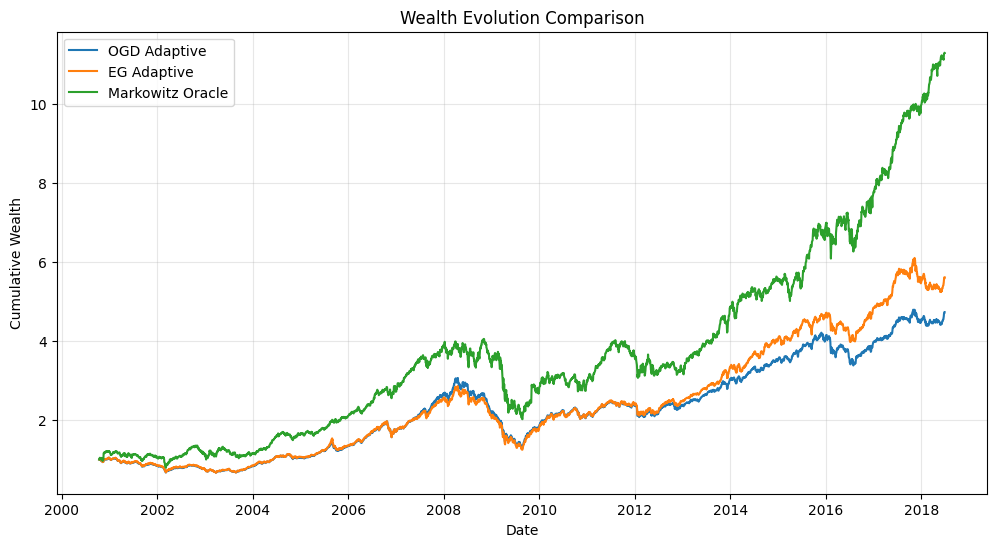

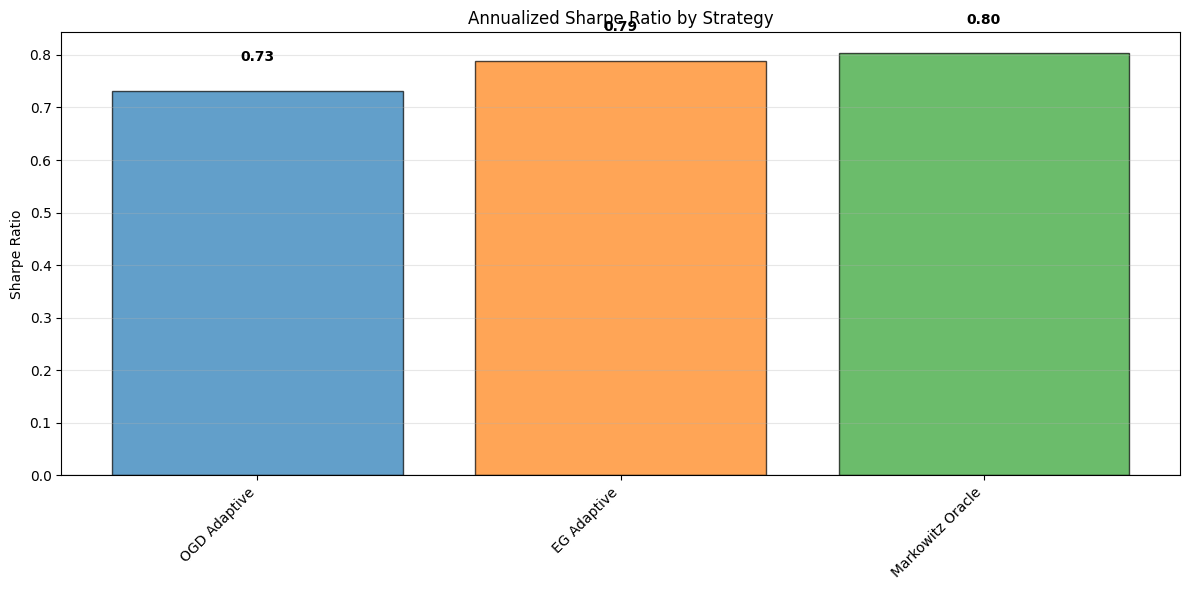

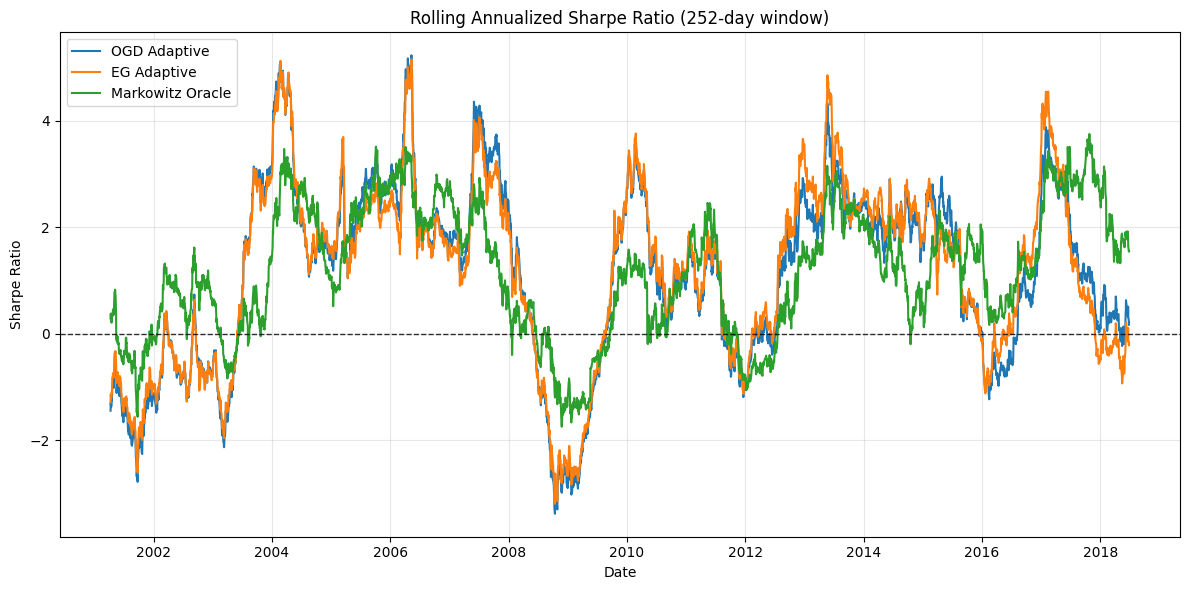

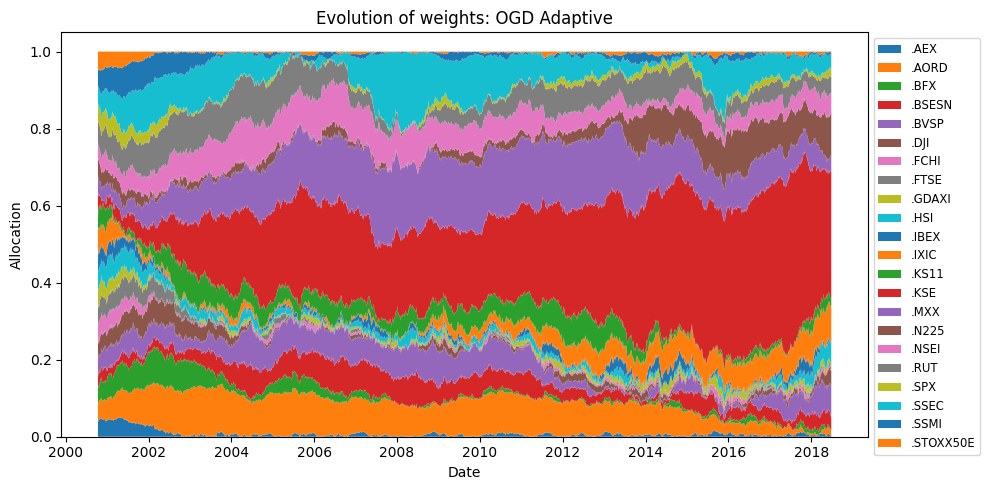

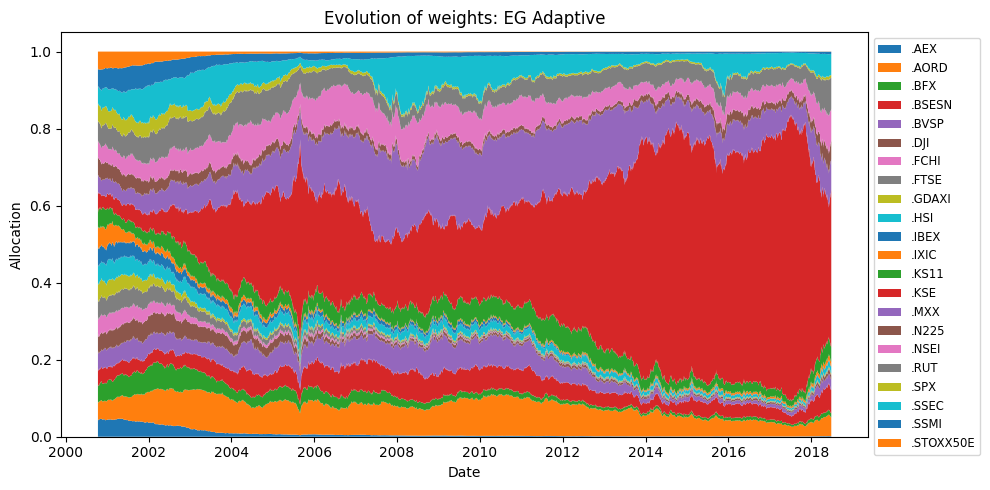

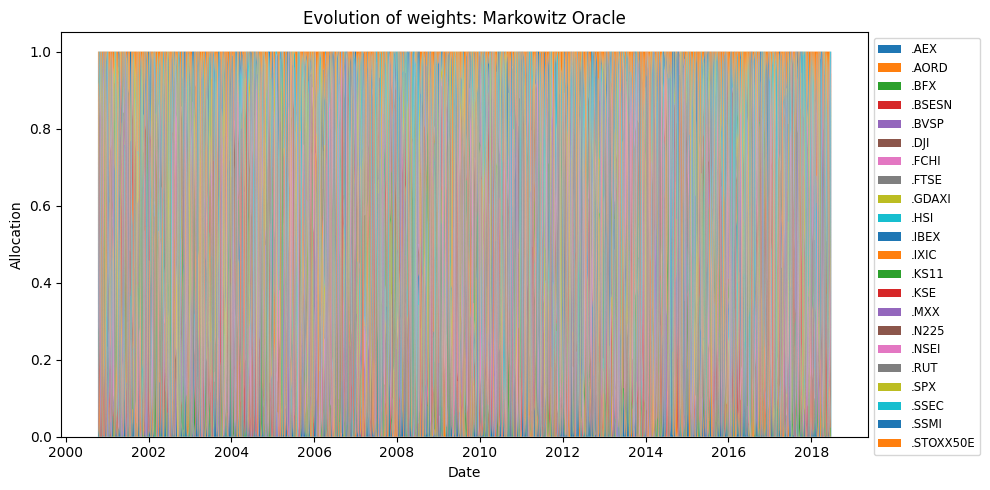

In [15]:
# 1. Dictionnaire des richesses (Wealth)
strategies_dict = {
    'OGD Adaptive': wealth_ogd_ada,
    'EG Adaptive': wealth_eg_ada,
    'Markowitz Oracle': wealth_marko_pred, # Votre version bruitée
}

# 2. Dictionnaire des historiques de poids (Optionnel)
# Note : Assurez-vous d'avoir sauvegardé hist_w_marko_pred dans la boucle précédente
weights_dict = {
    'OGD Adaptive': hist_w_ogd_ada,
    'EG Adaptive': hist_w_eg_ada,
    'Markowitz Oracle': hist_w_marko_pred
}

# 3. Appel de la fonction
plot_strategy_performance(
    strategies=strategies_dict,
    dates=dates,
    window=window,
    weight_histories=weights_dict, # Mettre None si vous ne voulez pas les stackplots
    assets=assets
)